<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/modeling_and_prediction_Quantile_LSTM_SeperateHeads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Novel Multi head Attention Qunatile LSTM

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow
!pip install keras

In [3]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Funktionen:

In [4]:
# Pfad zur CSV-Datei auf Google-Drive
name_Messwerte = 'Messdaten_CAMS_GHI.csv'
name_Vorhersage = 'Vorhersagedaten_CAMS_VarIdx.csv'
folder_import = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

In [5]:
# Pfad zum Abspeichern des trainierten Modells in Google-Drive

model_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/full_model.keras'
weights_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_weights.weights.h5'

# Pfad für den Testdatensatz

testdata_path_X = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata_X.csv'
testdata_path_Y = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata_Y.csv'

# Pfad für die Logdatei

text_file_path = "/content/drive/MyDrive/Colab_Notebooks/LSTM_Model/model_results.txt"

In [6]:
# Import der Messdaten
df_Messdaten = pd.read_csv(folder_import + name_Messwerte)

In [7]:
# Import der Vorhersagedaten
df_Vorhersage = pd.read_csv(folder_import + name_Vorhersage)

In [8]:
# Konvertiere die Zeitspalten in ein gemeinsames Format und führe einen Merge der Datensätze durch
df_Messdaten['Datetime'] = pd.to_datetime(df_Messdaten['Datetime'])
df_Vorhersage['Datetime'] = pd.to_datetime(df_Vorhersage['Datetime'])

In [9]:
# Spalten in den Messdaten
df_Messdaten.columns

Index(['Datetime', 'Observation_period', 'Clear_sky_GHI', 'Clear_sky_BHI',
       'GHI', 'BHI', 'UVI', 'UVA', 'UVB', 'erythem', 'Datum', 'Uhrzeit',
       'Messzeitpunkt', 'ghi', 'Dif', 'Glo_SPLite', 'Dir', 'Temp',
       'DiffGreater2', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos',
       'Date', 'Hour'],
      dtype='object')

## Funktionsdefinition:

In [10]:
def quantile_loss(q, y_true, y_pred):
    """Berechnet den Pinball Loss für mehrere Quantile."""
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e), axis=-1)  # Reduziere entlang der letzten Achse

In [11]:
def multi_quantile_loss(y_true, y_pred):
    losses = []
    for i, q in enumerate(quantiles):
        losses.append(quantile_loss(q, y_true[:, i], y_pred[:, i]))
    return tf.reduce_mean(losses)

## Config:

In [12]:
model_name = "LSTM_mit_Vorhersagewerten_1Step"

In [13]:
# Beispiel: Nur 'SZA' als Feature und 'UVI' als Label
columns_X = ['Clear_sky_GHI', 'Clear_sky_BHI', 'GHI', 'BHI', 'Temp', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos']
columns_y = ['UVI']

In [14]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

In [15]:
model_config = {
    "units_1": 64,
    "units_2": 32,
    "dropout_rate": 0.1,
    "final_activation": "linear"
}

In [16]:
training_config = {
    "loss": multi_quantile_loss,
    "optimizer": "adam",
    "metrics": [
        "mse",
        "mae",
        "mape",
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
}

In [17]:
fit_config = {
    "epochs": 40,
    "batch_size": 64,
    "sequence_length": 64
}

## Setup:

In [18]:
df = df_Messdaten.copy()  # deine Messdaten

total_length = len(df)
train_size   = round(total_length * 0.80)
val_size     = round(total_length * 0.10)
test_size    = total_length - train_size - val_size  # restliche 10%

# Skaliere X und Y separat (immer zuerst nur auf dem Trainingsbereich fitten!)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 1) Nur Trainingsdatensatz extrahieren
train_df = df.iloc[:train_size]
# Fit des Scalers NUR auf Trainingsdaten
train_df = df.iloc[:train_size].copy()
train_df.loc[:, columns_X] = scaler_X.fit_transform(train_df[columns_X])
train_df.loc[:, columns_y] = scaler_y.fit_transform(train_df[columns_y])

# 2) Für Validation
val_df = df.iloc[train_size : train_size + val_size].copy()
val_df[columns_X] = scaler_X.transform(val_df[columns_X])
val_df[columns_y] = scaler_y.transform(val_df[columns_y])

# 3) Für Test
test_df = df.iloc[train_size + val_size :].copy()
test_df[columns_X] = scaler_X.transform(test_df[columns_X])
test_df[columns_y] = scaler_y.transform(test_df[columns_y])

# Kontrolle
print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (77386, 26)
Val: (9673, 26)
Test: (9673, 26)


In [19]:
def create_sequence_OneStepAhead(X, y, seq_length):
    sequences = []
    labels = []
    # bis len(X)-1, damit "stop_idx + 1" nicht out-of-range ist
    for stop_idx in range(seq_length, len(X)-1):
        x_seq = X.iloc[stop_idx-seq_length:stop_idx].values
        y_label = y.iloc[stop_idx + 1]  # => label ist der nächste Zeitschritt
        sequences.append(x_seq)
        labels.append(y_label)
    return np.array(sequences), np.array(labels)

In [20]:
sequence_len = fit_config["sequence_length"]

X_train_seq, y_train_seq = create_sequence_OneStepAhead(train_df[columns_X], train_df[columns_y], sequence_len)
X_val_seq,   y_val_seq   = create_sequence_OneStepAhead(val_df[columns_X],   val_df[columns_y],   sequence_len)
X_test_seq,  y_test_seq  = create_sequence_OneStepAhead(test_df[columns_X],  test_df[columns_y],  sequence_len)

y_train_seq = np.tile(y_train_seq, (1, len(quantiles)))  # (77369, 5)
y_val_seq   = np.tile(y_val_seq, (1, len(quantiles)))
y_test_seq  = np.tile(y_test_seq, (1, len(quantiles)))

print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_val_seq:", X_val_seq.shape,"y_val_seq:", y_val_seq.shape)
print("X_test_seq:", X_test_seq.shape,"y_test_seq:",  y_test_seq.shape)

X_train_seq: (77321, 64, 10) y_train_seq: (77321, 5)
X_val_seq: (9608, 64, 10) y_val_seq: (9608, 5)
X_test_seq: (9608, 64, 10) y_test_seq: (9608, 5)


In [21]:
y_train_list = [y_train_seq[:, i] for i in range(len(quantiles))]
y_val_list   = [y_val_seq[:,   i] for i in range(len(quantiles))]
y_test_list  = [y_test_seq[:,  i] for i in range(len(quantiles))]

## Model Definition:

In [22]:
main_input = Input(shape=(sequence_len, len(columns_X)), name="main_input")

# Beispielhafte LSTM-Basis (2 LSTM-Schichten + Dropout)
x = LSTM(model_config["units_1"], return_sequences=True)(main_input)
x = Dropout(model_config["dropout_rate"])(x)
x = LSTM(model_config["units_2"], return_sequences=False)(x)
x = Dropout(model_config["dropout_rate"])(x)

# Separate Heads pro Quantil
heads = []
for i, q in enumerate(quantiles):
    out = Dense(1, activation=model_config["final_activation"], name=f"quantile_{int(q*100)}")(x)
    heads.append(out)

In [23]:
model = Model(inputs=main_input, outputs=heads)

In [24]:
losses = {}
for i, q in enumerate(quantiles):
    # "quantile_10", "quantile_25", usw.
    key_name = f"quantile_{int(q*100)}"
    losses[key_name] = (lambda y_true, y_pred, q=q: quantile_loss(q, y_true, y_pred))

In [25]:
metrics_dict = {}
for q in quantiles:
    key_name = f"quantile_{int(q*100)}"
    metrics_dict[key_name] = [
        "mse",
        "mae",
        "mape",
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]

In [26]:
model.compile(
    optimizer=training_config["optimizer"],
    loss=losses,
    metrics=metrics_dict
)

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)   │ (None, 64, 10)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64, 64)         │         19,200 │ main_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64)         │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_10 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_25 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_50 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_75 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_90 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 31,781 (124.14 KB)

 Trainable params: 31,781 (124.14 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    X_train_seq,
    y_train_list,              # Liste von 5 Arrays (eines pro Quantil)
    epochs=fit_config["epochs"],
    batch_size=fit_config["batch_size"],
    validation_data=(X_val_seq, y_val_list)
)

Epoch 1/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - loss: 0.0755 - quantile_10_loss: 0.0086 - quantile_10_mae: 0.0699 - quantile_10_mape: 9430.5488 - quantile_10_mse: 0.0144 - quantile_10_rmse: 0.1159 - quantile_25_loss: 0.0154 - quantile_25_mae: 0.0490 - quantile_25_mape: 8733.8975 - quantile_25_mse: 0.0086 - quantile_25_rmse: 0.0881 - quantile_50_loss: 0.0204 - quantile_50_mae: 0.0408 - quantile_50_mape: 5032.4980 - quantile_50_mse: 0.0056 - quantile_50_rmse: 0.0709 - quantile_75_loss: 0.0187 - quantile_75_mae: 0.0509 - quantile_75_mape: 5343.9219 - quantile_75_mse: 0.0077 - quantile_75_rmse: 0.0833 - quantile_90_loss: 0.0124 - quantile_90_mae: 0.0707 - quantile_90_mape: 4918.6270 - quantile_90_mse: 0.0126 - quantile_90_rmse: 0.1088 - val_loss: 0.0725 - val_quantile_10_loss: 0.0101 - val_quantile_10_mae: 0.0735 - val_quantile_10_mape: 42.3756 - val_quantile_10_mse: 0.0117 - val_quantile_10_rmse: 0.1084 - val_quantile_25_loss: 0.0172 - val_quantile_25_mae: 0.0490 - val_quantile_

In [29]:
preds = model.predict(X_test_seq)

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [30]:
preds_inverses = []
for i, q in enumerate(quantiles):
    # Hier shape anpassen, so dass invert_transform() es annimmt (2D)
    inv = scaler_y.inverse_transform(preds[i])
    preds_inverses.append(inv)

In [31]:
def compare_model_output_all_quantiles(model, X_test, y_test_list, quantiles, plot_indices=None):
    """
    Vergleicht Modellvorhersagen für alle Quantile in einem Plot.

    Parameter:
    ----------
    model         : Keras-Modell (Multi-Head) mit separaten Ausgängen für die Quantile.
    X_test        : numpy-Array für Test-Sequenzen (shape (n_samples, seq_len, n_features)).
    y_test_list   : Liste mit true-Werten pro Quantil (shape (n_samples,)),
                    i.d.R. alle identisch, falls sie getiled wurden.
    quantiles     : Liste mit Quantil-Werten (z.B. [0.1, 0.25, 0.5, 0.75, 0.9]).
    plot_indices  : Optionales Tupel (start, end), um einen Detailplot für diesen
                    Indexbereich zu erstellen.
    """
    # Vorhersagen berechnen: Liste von Arrays, eins pro Quantil, shape jeweils (n_samples, 1)
    preds_list = model.predict(X_test)

    # Falls alle y_test_list[i] identisch sind (z.B. wegen np.tile):
    # Dann können wir einmal das "wahre" y aus dem ersten Eintrag nehmen
    y_true = y_test_list[0].flatten()

    # Vorbereitung zur Speicherung der Metriken
    metrics_data = []

    # Flatten und Metrik-Berechnung pro Quantil
    for i, q in enumerate(quantiles):
        y_pred = preds_list[i].flatten()        # Vorhersagen für Quantil q
        y_test_q = y_test_list[i].flatten()     # True-Werte (bei np.tile identisch)

        # Metriken berechnen
        mse = mean_squared_error(y_test_q, y_pred)
        mae = mean_absolute_error(y_test_q, y_pred)

        metrics_data.append((q, mse, mae))

    # --- 1) Plot für den gesamten Bereich ---
    plt.figure(figsize=(12, 5))

    # Plot der True-Werte
    plt.plot(y_true, label='Tatsächlicher Wert (y)', color='black', linewidth=2, alpha=0.7)

    # Plot der Vorhersagen aller Quantile
    for i, q in enumerate(quantiles):
        plt.plot(preds_list[i].flatten(), label=f'Q={q}', alpha=0.7)

    plt.title('Vorhersage für alle Quantile (gesamter Bereich)')
    plt.legend()
    plt.show()

    # --- 2) Optionaler Detail-Plot ---
    if plot_indices is not None:
        start, end = plot_indices
        plt.figure(figsize=(12, 5))

        # Plot der True-Werte im angegebenen Bereich
        plt.plot(np.arange(start, end), y_true[start:end], label='Tatsächlicher Wert (y)',
                 color='black', linewidth=2, alpha=0.7)

        # Plot der Vorhersagen aller Quantile im Detail-Bereich
        for i, q in enumerate(quantiles):
            y_pred = preds_list[i].flatten()
            plt.plot(np.arange(start, end), y_pred[start:end], label=f'Q={q}', alpha=0.7)

        plt.title(f'Detailplot aller Quantile (Index {start} - {end})')
        plt.legend()
        plt.show()

    # --- 3) Zusammenfassung der Metriken ausgeben ---
    print("Metriken pro Quantil:")
    for (q, mse, mae) in metrics_data:
        print(f"Quantil {q}: MSE={mse:.4f}, MAE={mae:.4f}")


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


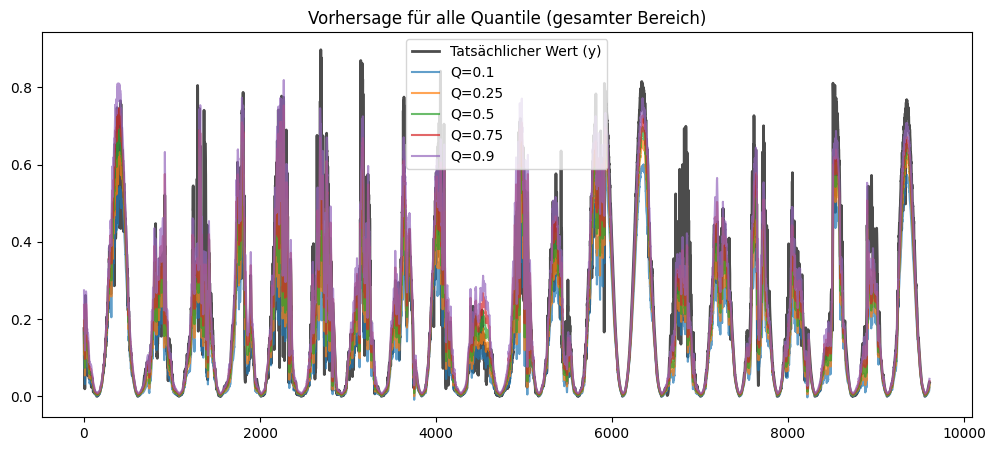

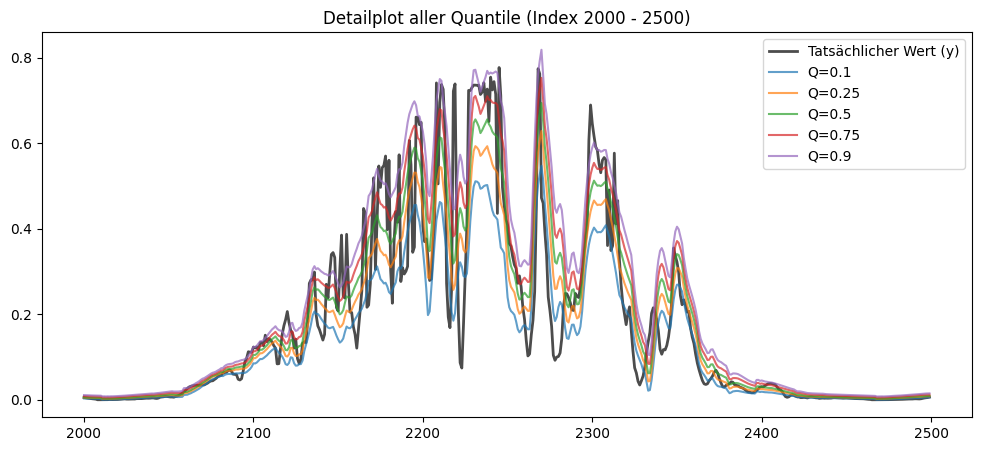

Metriken pro Quantil:
Quantil 0.1: MSE=0.0106, MAE=0.0662
Quantil 0.25: MSE=0.0066, MAE=0.0509
Quantil 0.5: MSE=0.0054, MAE=0.0455
Quantil 0.75: MSE=0.0055, MAE=0.0462
Quantil 0.9: MSE=0.0071, MAE=0.0522


In [32]:
compare_model_output_all_quantiles(
    model=model,
    X_test=X_test_seq,
    y_test_list=y_test_list,
    quantiles=quantiles,
    plot_indices=(2000, 2500)  # Beispielhafter Index-Bereich fürs Detailplot
)

In [33]:
def check_quantile_violations(model, X_test, y_test_seq):
    """
    Berechnet, wie oft die gemessenen Werte (y_true) das 10%- und 25%-Quantil unterschreiten,
    sowie das 75%- und 90%-Quantil überschreiten. Gibt außerdem die prozentualen Anteile
    (bezogen auf alle Datenpunkte) zurück.

    Parameter:
    ----------
    model       : Keras Multi-Head-Quantile-Modell
    X_test      : numpy-Array (N, sequence_length, num_features)
    y_test_seq  : numpy-Array (N, 5) oder (N, 1), in der Regel getiled,
                  so dass in jeder Spalte der gleiche true-Wert steht.

    Rückgabe:
    ----------
    dict
        Dictionary mit absoluten Anzahlen und prozentualen Anteilen.
    """

    # 1) Echte Y-Werte (1D) extrahieren:
    #    Wenn y_test_seq.shape == (N, 5), ist jede Spalte identisch.
    #    Wir nehmen einfach die erste Spalte als "wahren Wert".
    y_true = y_test_seq[:, 0]

    # 2) Vorhersagen vom Multi-Head-Modell abrufen (Liste aus 5 Arrays)
    pred_list = model.predict(X_test)
    # pred_list z.B. = [ array(N,1), array(N,1), array(N,1), array(N,1), array(N,1) ]
    # Die Reihenfolge entspricht den Quantilen [0.1, 0.25, 0.5, 0.75, 0.9]

    # 3) Zu einer 2D-Matrix (N, 5) zusammenführen (spaltenweise)
    y_pred_2d = np.hstack(pred_list)  # shape (N, 5)
    # Spalten: [q10, q25, q50, q75, q90]

    # 4) Quantile interpretieren
    #    y_pred_2d[:, 0] => 10%-Quantil
    #    y_pred_2d[:, 1] => 25%-Quantil
    #    y_pred_2d[:, 2] => 50%-Quantil
    #    y_pred_2d[:, 3] => 75%-Quantil
    #    y_pred_2d[:, 4] => 90%-Quantil

    n = len(y_true)  # Gesamtzahl der Datenpunkte

    # 5) Absolutzahlen für Verletzungen berechnen
    below_10p = np.sum(y_true < y_pred_2d[:, 0])
    below_25p = np.sum(y_true < y_pred_2d[:, 1])
    above_75p = np.sum(y_true > y_pred_2d[:, 3])
    above_90p = np.sum(y_true > y_pred_2d[:, 4])

    # 6) Prozentsätze berechnen
    below_10p_pct = round((below_10p / n) * 100, 2)
    below_25p_pct = round((below_25p / n) * 100, 2)
    above_75p_pct = round((above_75p / n) * 100, 2)
    above_90p_pct = round((above_90p / n) * 100, 2)

    return {
        'below_10_percentile': {
            'count': below_10p,
            'percentage': below_10p_pct
        },
        'below_25_percentile': {
            'count': below_25p,
            'percentage': below_25p_pct
        },
        'above_75_percentile': {
            'count': above_75p,
            'percentage': above_75p_pct
        },
        'above_90_percentile': {
            'count': above_90p,
            'percentage': above_90p_pct
        }
    }

In [34]:
results = check_quantile_violations(model, X_test_seq, y_test_seq)

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [35]:
results

{'below_10_percentile': {'count': 1434, 'percentage': 14.925062447960032},
 'below_25_percentile': {'count': 3058, 'percentage': 31.827643630308078},
 'above_75_percentile': {'count': 3973, 'percentage': 41.35095753538718},
 'above_90_percentile': {'count': 2759, 'percentage': 28.71565362198168}}